In [1]:
# preprocess
import numpy as np
from PIL import Image

def preprocess(image):
    # Resize
    ratio = 800.0 / min(image.size[0], image.size[1])
    image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])), Image.BILINEAR)

    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # Pad to be divisible of 32
    import math
    padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    padded_image[:, :image.shape[1], :image.shape[2]] = image
    image = padded_image

    return image

img = Image.open('bus.jpg')
img_data = preprocess(img)

In [9]:
img_data.shape

(3, 1088, 800)

In [2]:
# ONNXRuntime
import onnxruntime as ort

ort_session = ort.InferenceSession(
    './onnx/mask_rcnn_R_50_FPN_1x.onnx', providers=['CPUExecutionProvider'])

# OpenVINO
from openvino.runtime import Core, AsyncInferQueue

ie = Core()
onnx_model_path = './onnx/mask_rcnn_R_50_FPN_1x.onnx'
model_onnx = ie.read_model(model=onnx_model_path)
input_layer = next(iter(model_onnx.inputs))
compiled_model_onnx = ie.compile_model(
    model=model_onnx,
    device_name='CPU',
    config={"PERFORMANCE_HINT": "THROUGHPUT"})
request = compiled_model_onnx.create_infer_request()

# input
import numpy as np

image_input = img_data

ort_output = ort_session.run(None,
                             {ort_session.get_inputs()[0].name: image_input})
request.infer({input_layer.any_name: image_input})
ov_output_boxes_0 = request.get_output_tensor(0).data
ov_output_labels_1 = request.get_output_tensor(1).data
ov_output_scores_2 = request.get_output_tensor(2).data
ov_output_masks_3 = request.get_output_tensor(3).data

np.testing.assert_allclose(ov_output_boxes_0, ort_output[0], rtol=1e-03, atol=1e-05)
np.testing.assert_allclose(ov_output_labels_1, ort_output[1], rtol=1e-03, atol=1e-05)
np.testing.assert_allclose(ov_output_scores_2, ort_output[2], rtol=1e-03, atol=1e-05)
np.testing.assert_allclose(ov_output_masks_3, ort_output[3], rtol=1e-03, atol=1e-05)

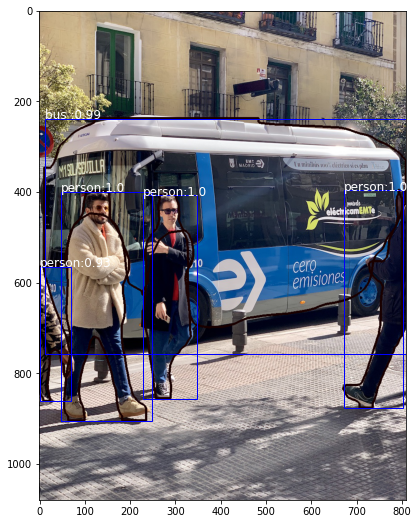

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

CLASSES = ["__background", "person", "bicycle", "car", "motorbike ", "aeroplane ", "bus ",
           "train", "truck ", "boat", "traffic light", "fire hydrant",
           "stop sign ", "parking meter", "bench", "bird", "cat", "dog ",
           "horse ", "sheep", "cow", "elephant", "bear", "zebra ", "giraffe",
           "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
           "skis", "snowboard", "sports ball", "kite", "baseball bat",
           "baseball glove", "skateboard", "surfboard", "tennis racket",
           "bottle", "wine glass", "cup", "fork", "knife ", "spoon", "bowl",
           "banana", "apple", "sandwich", "orange", "broccoli", "carrot",
           "hot dog", "pizza ", "donut", "cake", "chair", "sofa",
           "pottedplant", "bed", "diningtable", "toilet ", "tvmonitor",
           "laptop	", "mouse	", "remote ", "keyboard ", "cell phone",
           "microwave ", "oven ", "toaster", "sink", "refrigerator ", "book",
           "clock", "vase", "scissors ", "teddy bear ", "hair drier",
           "toothbrush "]

def display_objdetect_image(image, boxes, labels, scores, masks, score_threshold=0.7):
    # Resize boxes
    ratio = 800.0 / min(image.size[0], image.size[1])
    boxes /= ratio

    _, ax = plt.subplots(1, figsize=(12,9))

    image = np.array(image)

    for mask, box, label, score in zip(masks, boxes, labels, scores):
        # Showing boxes with score > 0.7
        if score <= score_threshold:
            continue

        # Finding contour based on mask
        mask = mask[0, :, :, None]
        int_box = [int(i) for i in box]
        mask = cv2.resize(mask, (int_box[2]-int_box[0]+1, int_box[3]-int_box[1]+1))
        mask = mask > 0.5
        im_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        x_0 = max(int_box[0], 0)
        x_1 = min(int_box[2] + 1, image.shape[1])
        y_0 = max(int_box[1], 0)
        y_1 = min(int_box[3] + 1, image.shape[0])
        mask_y_0 = max(y_0 - box[1], 0)
        mask_y_1 = mask_y_0 + y_1 - y_0
        mask_x_0 = max(x_0 - box[0], 0)
        mask_x_1 = mask_x_0 + x_1 - x_0
        im_mask[y_0:y_1, x_0:x_1] = mask[
            mask_y_0 : mask_y_1, mask_x_0 : mask_x_1
        ]
        im_mask = im_mask[:, :, None]

        # OpenCV version 4.x
        contours, hierarchy = cv2.findContours(
            im_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )

        image = cv2.drawContours(image, contours, -1, 25, 3)

        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='b', facecolor='none')
        ax.annotate(CLASSES[label] + ':' + str(np.round(score, 2)), (box[0], box[1]), color='w', fontsize=12)
        ax.add_patch(rect)

    ax.imshow(image)
    plt.show()

boxes, labels, scores, masks = ort_output
display_objdetect_image(img, boxes, labels, scores, masks)

In [5]:
import time
   
warm_up_iters = 10
inference_iters = 100

# onnxruntime 
ort_inputs = {ort_session.get_inputs()[0].name: image_input}
# warm up
for _ in range(warm_up_iters):
    ort_session.run(None, ort_inputs)
# inference test
start_time = time.time()
for _ in range(inference_iters):
    ort_session.run(None, ort_inputs)
ort_time = time.time() - start_time
print(f'onnxruntime: {ort_time:.2f} s')

# openvino
compiled_model_onnx = ie.compile_model(
    model=model_onnx,
    device_name='CPU',
    config={"PERFORMANCE_HINT": "THROUGHPUT"})
infer_queue = AsyncInferQueue(compiled_model_onnx, 16)
# warm up
for _ in range(warm_up_iters):
    infer_queue.start_async(inputs={input_layer.any_name: image_input})
infer_queue.wait_all()
# inference test
start_time = time.time()
for _ in range(inference_iters):
    infer_queue.start_async(inputs={input_layer.any_name: image_input})
infer_queue.wait_all()
ov_time = time.time() - start_time
print(f'openvino-fp32: {ov_time:.2f} s')

onnxruntime: 70.59 s
openvino-fp32: 18.49 s
